In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
from mprompt.modules.emb_diff_module import EmbDiffModule
import numpy as np
import matplotlib
import imodelsx.util
from copy import deepcopy
import re
import notebook_helper
import mprompt.viz
import scipy.special
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from mprompt.methods.m4_evaluate import D5_Validator
import openai
from mprompt.modules.fmri_module import fMRIModule
from pprint import pprint
import joblib
import viz
from mprompt.config import RESULTS_DIR
import torch.cuda


EXPT_NAME = 'relationships_mar9'
rows = joblib.load(join(RESULTS_DIR, 'stories', f'{EXPT_NAME}_rows.pkl'))
expls = rows.expl.values
voxel_nums = rows.module_num.values
subjects = rows.subject.values
paragraphs = rows.paragraph.values
prompts = rows.prompt.values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Heatmaps

**Data** <> Explanation Heatmap

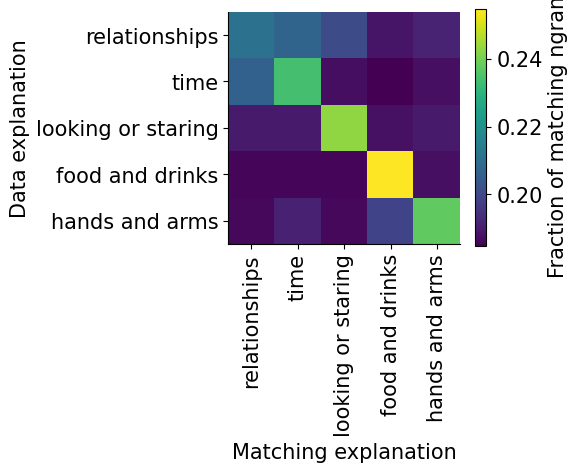

<Figure size 640x480 with 0 Axes>

In [3]:
scores_data = joblib.load(join(RESULTS_DIR, 'stories', f'{EXPT_NAME}_scores_data.pkl'))
s = scores_data
s = scipy.special.softmax(s, axis=1)
# s = (s - s.min()) / (s.max() - s.min())
mprompt.viz.heatmap(s, expls, ylab='Data explanation', xlab='Matching explanation')
plt.savefig(join(RESULTS_DIR, 'stories', f'{EXPT_NAME}_story_data_match.png'), dpi=300)

**Module** <> Explanation Heatmap

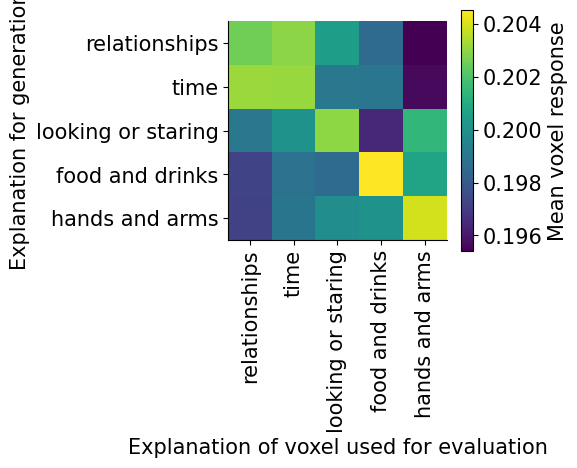

<Figure size 640x480 with 0 Axes>

In [4]:
# keys: scores_mod, scores_max_mod, all_scores, all_ngrams
scores_mod_dict = joblib.load(join(RESULTS_DIR, 'stories', f'{EXPT_NAME}_scores_mod.pkl'))

s = scores_mod_dict['scores_mod']
s = scipy.special.softmax(s, axis=1)
# s = (s - s.min()) / (s.max() - s.min())
mprompt.viz.heatmap(s, expls, xlab='Explanation of voxel used for evaluation', clab='Mean voxel response')
plt.savefig(join(RESULTS_DIR, 'stories', f'{EXPT_NAME}_story_mod_match.png'), dpi=300)

### Story visualization

**Data** <> Story match

In [5]:
s_data = ''
scores_data_story = joblib.load(join(RESULTS_DIR, 'stories', f'{EXPT_NAME}_scores_data_story.pkl'))
for i in range(len(paragraphs)):
    scores_i = np.array(scores_data_story[i])

    # normalize to 0-1 range
    scores_i = (scores_i - scores_i.min()) / (scores_i.max() - scores_i.min())
    # scores_mod_i = scipy.special.softmax(scores_mod_i)
    scores_i = mprompt.viz.moving_average(scores_i, n=3)
    scores_i = scores_i / 2 + 0.5 # shift to 0.5-1 range
    s_data += ' ' + mprompt.viz.colorize(paragraphs[i].split(), scores_i, title=expls[i], subtitle=prompts[i])
# display(HTML(s_data))

**Module** <> Story Match

In [9]:
s_mod = ''
scores_mod_story = [scores_mod_dict['all_scores'][i][i] for i in range(len(scores_mod_dict['all_scores']))]
for i in range(len(paragraphs)):
    scores_i = scores_mod_story[i]

    # normalize to 0-1 range
    scores_i = (scores_i - scores_i.min()) / (scores_i.max() - scores_i.min())
    # scores_mod_i = scipy.special.softmax(scores_mod_i)
    # scores_i = mprompt.viz.moving_average(scores_i, n=3)
    scores_i = scores_i / 2 + 0.5 # shift to 0.5-1 range
    s_mod += ' ' + mprompt.viz.colorize(paragraphs[i].split(), scores_i, title=expls[i], subtitle=prompts[i])
# display(HTML(s_mod))

In [10]:
template_style = '''<style type="text/css">
#wrap {
   width:100%;
   margin:0 auto;
}
#left_col {
   float:left;
   width:48%;
}
#right_col {
   float:right;
   width:48%;
}
# body {
#     background-color:#b0c4de;
# }
</style>
'''

template = '''
<body>
    <div id="wrap">
        <div id="left_col">
            {col_left}
        </div>
        <div id="right_col">
            {col_right}
        </div>
    </div>
</body>
'''

In [11]:
display(HTML(template_style + template.format(col_left=s_data, col_right=s_mod)), metadata=dict(isolated=True))